In [1]:
versioninfo()

Julia Version 1.11.1
Commit 8f5b7ca12a (2024-10-16 10:53 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 8 × Intel(R) Core(TM) i7-9700K CPU @ 3.60GHz
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, skylake)
Threads: 1 default, 0 interactive, 1 GC (on 8 virtual cores)
Environment:
  JULIA_DEPOT_PATH = E:\Users\tate\.julia
  JULIA_PYTHONCALL_EXE = python


In [2]:
using Pkg
Pkg.activate(".")

  Activating project at `E:\Users\tate\Repo\article-logm-preconditioning`


In [3]:
using LinearAlgebra

using MatrixDepot
using PythonPlot

PythonPlot.matplotlib.rcParams["font.size"] = 10
PythonPlot.matplotlib.rcParams["axes.titlesize"] = 10;

[ Info: verify download of index files...
[ Info: reading database


EOFError()


┌ Warning: recreating database file
└ @ MatrixDepot E:\Users\tate\.julia\packages\MatrixDepot\4S7Oa\src\download.jl:59
[ Info: reading index files
[ Info: adding metadata...
[ Info: adding svd data...
[ Info: writing database
┌ Warning: exception during initialization: 'KeyError(MatrixDepot)'
└ @ MatrixDepot E:\Users\tate\.julia\packages\MatrixDepot\4S7Oa\src\MatrixDepot.jl:125


In [4]:
"""
Computing the eigenvalues/eigenvectors of 
a symmetric tridiag Toeplitz matrices with size n
whose diagonals are d0 and subdiagonals are d1.
"""
function eigen_sttm(d0, d1, n)
    λ = [d0 + d1*2*cos(j*big(π)/(n+1)) for j=1:n]
    Q = [
        begin
            x = (i*j) // (n+1)
            a = (i*j) ÷ (n+1)
            b = x - big(a)
            (-1)^a * sin(b*π)
        end
        for i=1:n, j=1:n
    ]
    for j = 1:n
        Q[:, j] .= normalize(Q[:, j])
    end
    return λ, Q
end

eigen_sttm

In [5]:
n = 200

# reference_solution
λ, Q = eigen_sttm(2, -1, n)
λ_max, λ_min = maximum(λ), minimum(λ)
c = 1 / sqrt(λ_max*λ_min)
log_Ã = Float64.(Q * Diagonal(log.(λ) .+ log(c)) * Q');

# computing ÃP̃ and P̃ exactry
P̃ = Q * Diagonal(@. 1 / (c*λ + 1)) * Q' |> X -> Float64.(X)
log_P̃ = (Q * Diagonal(@. -log(c*λ + 1)) * Q') |> X -> Float64.(X)
ÃP̃ = Q * Diagonal(@. c*λ / (c*λ + 1)) * Q' |> X -> Float64.(X)
log_ÃP̃ = Q * Diagonal(@. log(c*λ) - log(c*λ + 1)) * Q' |> X -> Float64.(X);

# Test matrix
d0 = fill(2.0, n)
d1 = fill(-1.0, n-1)

A = diagm(-1=>d1, 0=>d0, 1=>d1)
λ = [2 - 2*cos(j*π/(n+1)) for j=1:n]
λ_max, λ_min = maximum(λ), minimum(λ)
c = 1 / sqrt(λ_max*λ_min)
Ã = c*A
# κ = λ_max / λ_min
# sκ = sqrt(κ)
# cc = sqrt((sκ+1)*(1/sκ + 1)) # = c' = c''

200×200 Matrix{Float64}:
  63.9829  -31.9914    0.0       0.0     …    0.0       0.0       0.0
 -31.9914   63.9829  -31.9914    0.0          0.0       0.0       0.0
   0.0     -31.9914   63.9829  -31.9914       0.0       0.0       0.0
   0.0       0.0     -31.9914   63.9829       0.0       0.0       0.0
   0.0       0.0       0.0     -31.9914       0.0       0.0       0.0
   0.0       0.0       0.0       0.0     …    0.0       0.0       0.0
   0.0       0.0       0.0       0.0          0.0       0.0       0.0
   0.0       0.0       0.0       0.0          0.0       0.0       0.0
   0.0       0.0       0.0       0.0          0.0       0.0       0.0
   0.0       0.0       0.0       0.0          0.0       0.0       0.0
   0.0       0.0       0.0       0.0     …    0.0       0.0       0.0
   0.0       0.0       0.0       0.0          0.0       0.0       0.0
   0.0       0.0       0.0       0.0          0.0       0.0       0.0
   ⋮                                     ⋱                      


In [6]:
include("src/SPDLogmPrecQuad.jl")
using ..SPDLogmPrecQuad

In [7]:
m_list = 4:4:100
l = length(m_list)
err_de = zeros(l)
err_gl = zeros(l)
err_pgl = zeros(l)
err_gl_ÃP̃ = zeros(l)
err_gl_P̃ = zeros(l)

μ_max, μ_min = c*λ_max / (c*λ_max + 1), c*λ_min / (c*λ_min + 1)
ν_max, ν_min = 1 / (c*λ_min + 1), 1 / (c*λ_max + 1)

for (i, m) in enumerate(m_list)
    err_de[i] = opnorm(log_Ã - logm_de(Ã, c*λ_max, c*λ_min, m=m).X)
    err_gl[i] = opnorm(log_Ã - logm_gl(Ã, c*λ_max, c*λ_min, m=m).X)
    err_pgl[i] = opnorm(log_Ã - logm_pgl(Ã, c*λ_max, c*λ_min, m=m÷2).X)
    err_gl_ÃP̃[i] = opnorm(log_ÃP̃ - logm_gl(ÃP̃, μ_max, μ_min, m=m).X)
    err_gl_P̃[i] = opnorm(log_P̃ - logm_gl(P̃, ν_max, ν_min, m=m).X)
end

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


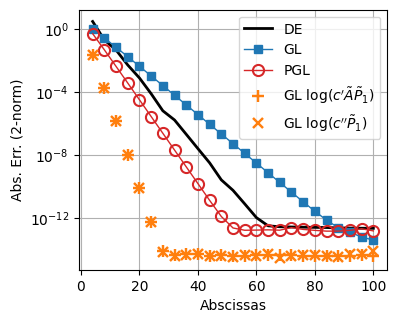

In [8]:
fig, ax = subplots(1, 1, figsize=[11, 9]/2.7)

ax.plot(m_list, err_de, label="DE", lw=2, c="k")
ax.plot(m_list, err_gl, label="GL", c="tab:blue", marker="s", lw=1)
ax.plot(m_list, err_pgl, label="PGL", c="tab:red", marker="o", lw=1, mew=1.5, mfc="none", ms=8)
ax.plot(m_list, err_gl_ÃP̃, label="GL \$\\log(c'\\tilde{A}\\tilde{P}_1)\$", c="tab:orange", lw=0, marker="+", ms=9, mew=1.75)
ax.plot(m_list, err_gl_P̃, label="GL \$\\log(c''\\tilde{P}_1)\$", c="tab:orange", lw=0, marker="x", ms=7, mew=1.75)
ax.set_xlabel("Abscissas")
ax.set_ylabel("Abs. Err. (2-norm)")
ax.set_yscale("log")
ax.set_yticks([1e-12, 1e-8, 1e-4, 1e0])
ax.grid()
ax.legend()
fig.tight_layout()
fig.savefig("fig/history.pdf")
plotshow()